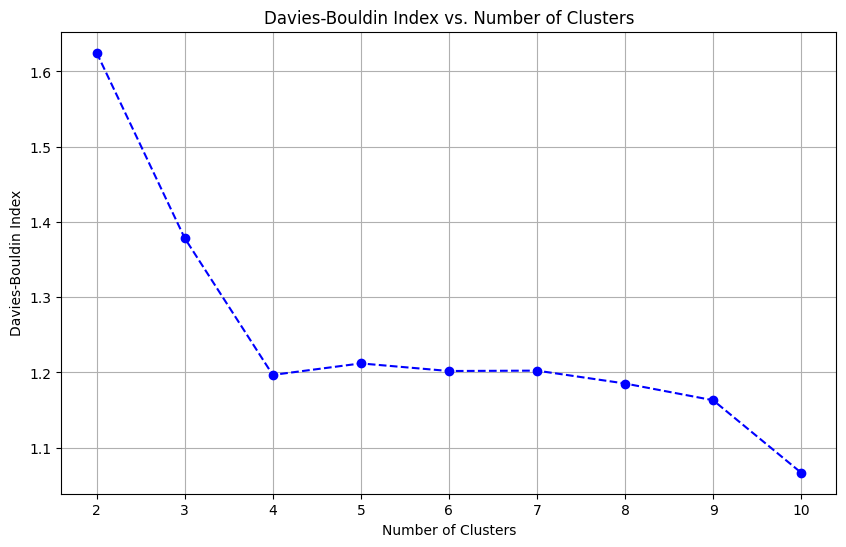

Optimal number of clusters: 10, DB Index: 1.0668


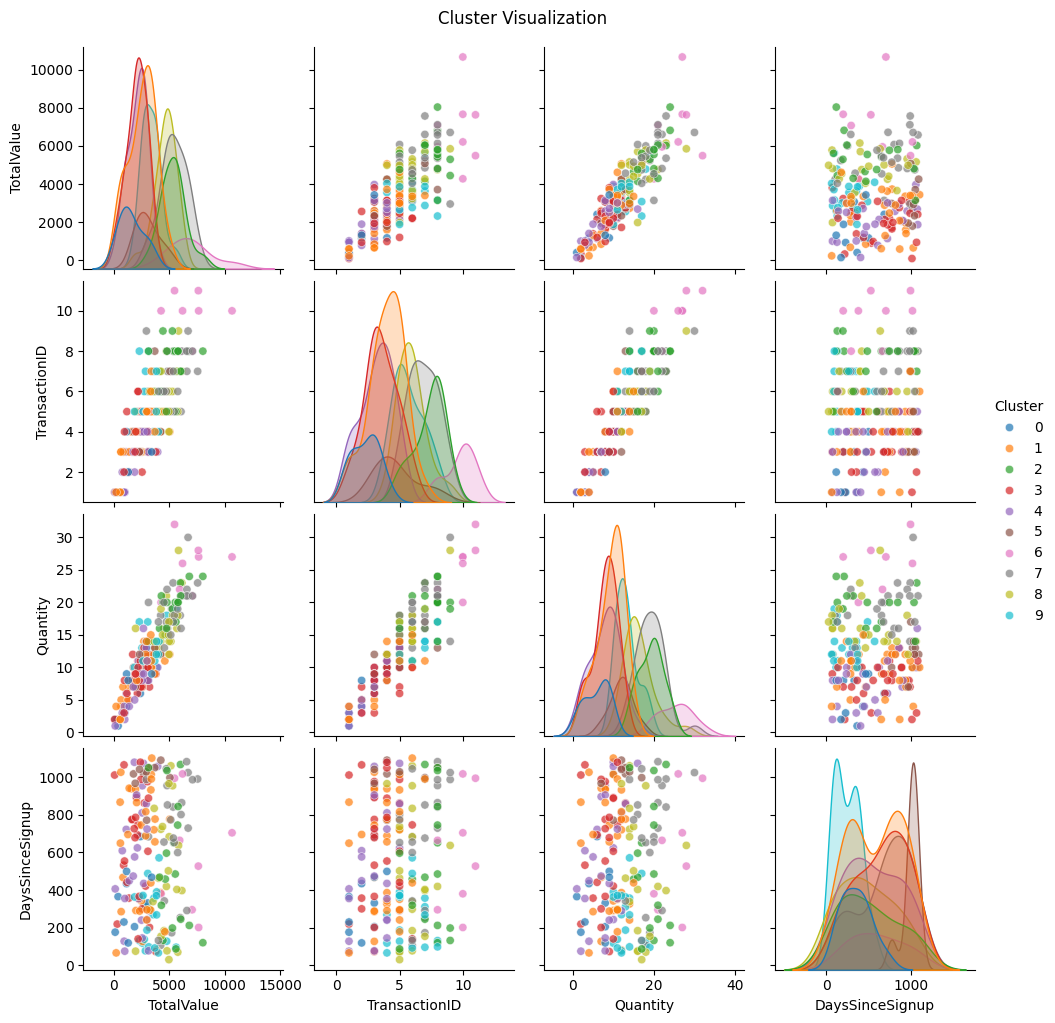

Cluster Summary:
         TotalValue  TransactionID  Quantity  DaysSinceSignup
Cluster                                                      
0           1585.41           2.30      5.80           351.10
1           2561.33           3.97      9.37           588.17
2           5330.46           7.35     19.24           512.47
3           2080.98           3.54      8.00           649.89
4           2124.87           3.19      7.96           559.92
5           3076.28           4.78     12.00           997.56
6           6870.64           9.75     25.38           597.75
7           5404.41           6.88     19.21           687.08
8           4633.96           5.95     16.38           476.33
9           3366.29           5.71     13.19           250.10


In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Merge datasets
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

# Aggregate customer features
customer_features = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',          # Total spend
    'TransactionID': 'count',     # Number of transactions
    'Quantity': 'sum',            # Total quantity purchased
    'Region': 'first',            # Region information
    'SignupDate': 'first'         # Signup date
}).reset_index()

# Convert SignupDate to numeric (days since signup)
customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'])
customer_features['DaysSinceSignup'] = (pd.Timestamp.now() - customer_features['SignupDate']).dt.days

# Drop unneeded columns and encode categorical data
customer_features = customer_features.drop(columns=['SignupDate'])
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))

# Find optimal number of clusters using Davies-Bouldin Index
cluster_range = range(2, 11)
db_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(normalized_features)
    db_index = davies_bouldin_score(normalized_features, cluster_labels)
    db_scores.append(db_index)

# Plot Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, db_scores, marker='o', linestyle='--', color='b')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(cluster_range)
plt.grid()
plt.show()

# Optimal number of clusters
optimal_k = cluster_range[db_scores.index(min(db_scores))]
print(f"Optimal number of clusters: {optimal_k}, DB Index: {min(db_scores):.4f}")

# Finalize clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_features['Cluster'] = kmeans_final.fit_predict(normalized_features)

# Visualize clusters
sns.pairplot(customer_features, vars=['TotalValue', 'TransactionID', 'Quantity', 'DaysSinceSignup'], 
             hue='Cluster', palette='tab10', diag_kind='kde', plot_kws={'alpha': 0.7})
plt.suptitle('Cluster Visualization', y=1.02)
plt.show()

# Cluster summary
cluster_summary = customer_features.groupby('Cluster').agg({
    'TotalValue': 'mean',
    'TransactionID': 'mean',
    'Quantity': 'mean',
    'DaysSinceSignup': 'mean'
}).round(2)

print("Cluster Summary:")
print(cluster_summary)

# Save the results
customer_features.to_csv("Customer_Clusters.csv", index=False)

In [3]:
# Calculate Within-Cluster Sum of Squares (WCSS)
wcss = kmeans_final.inertia_
print(f"Within-Cluster Sum of Squares (WCSS): {wcss:.4f}")

Within-Cluster Sum of Squares (WCSS): 354.0240


In [4]:
# Count number of points per cluster
cluster_sizes = customer_features['Cluster'].value_counts()
print("Number of Points in Each Cluster:")
print(cluster_sizes)

Number of Points in Each Cluster:
Cluster
1    35
3    28
4    26
7    24
9    21
8    21
2    17
0    10
5     9
6     8
Name: count, dtype: int64
